In [9]:
print("✅ 라이브러리 로딩 시작...")
import joblib
from sklearn.ensemble import ExtraTreesClassifier
import pandas as pd
import numpy as np
import time
import os
import warnings
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')
print("✅ 라이브러리 로딩 완료!")

# =======================================================
# 🧹 1단계: 정제된 데이터 로딩
# =======================================================
print("\n" + "="*80)
print("🧹 1단계: 정제된 데이터 로딩")
print("="*80)
print("📂 이전 단계에서 생성한 '정제된' 데이터 파일을 불러옵니다...")
try:
    flow_data = joblib.load("task2_data/train_flow_data_cleaned.pkl")
    all_packets = joblib.load("task2_data/train_packet_data_cleaned.pkl")
    print(f"✅ 정제된 Flow 데이터 ({len(flow_data):,}개) 로딩 완료")
    print(f"✅ 정제된 Packet 데이터 ({len(all_packets):,}개) 로딩 완료")
except FileNotFoundError:
    print("❌ 정제된 파일을 찾을 수 없습니다!")
    print("   먼저 이전 파이프라인의 '데이터 정제' 부분을 실행하여 _cleaned.pkl 파일을 생성해주세요.")
    exit()

✅ 라이브러리 로딩 시작...
✅ 라이브러리 로딩 완료!

🧹 1단계: 정제된 데이터 로딩
📂 이전 단계에서 생성한 '정제된' 데이터 파일을 불러옵니다...
✅ 정제된 Flow 데이터 (381,559개) 로딩 완료
✅ 정제된 Packet 데이터 (381,559개) 로딩 완료


In [10]:
# =======================================================
# 🎯 2단계: 대표 샘플 생성
# =======================================================
print("\n" + "="*80)
print("🎯 2단계: 대표 샘플 생성 (층화 추출)")
print("="*80)
# 👈 새로운 특징 추출은 계산 비용이 높으므로, 먼저 5만개로 빠르게 테스트합니다.
target_total_samples = 50000  
print(f"🎯 목표 총 샘플 수: {target_total_samples:,}개")
stratify_key = flow_data['duration_class'].astype(str) # 이제 duration 기준으로 층화
stratified_sampler = StratifiedShuffleSplit(n_splits=1, train_size=target_total_samples, random_state=42)
indices = np.arange(len(flow_data))
sampled_indices, _ = next(stratified_sampler.split(indices, stratify_key))
print(f"✅ 샘플링 완료! 총 {len(sampled_indices):,}개 대표 샘플 인덱스 확보.")


🎯 2단계: 대표 샘플 생성 (층화 추출)
🎯 목표 총 샘플 수: 50,000개
✅ 샘플링 완료! 총 50,000개 대표 샘플 인덱스 확보.


In [11]:
def extract_packet_features(packets, n=3):
    features = {}
    num_packets = min(n, len(packets))
    if num_packets == 0:
        return features
    packets = packets.iloc[:num_packets]
    
    numeric_cols = packets.select_dtypes(include=[np.number]).columns
    for col in numeric_cols:
        features[f'first_{col}'] = packets.iloc[0][col] if col in packets.columns else 0
        features[f'second_{col}'] = packets.iloc[1][col] if col in packets.columns and num_packets > 1 else 0
    
    if 'ip_len' in packets.columns:
        ip_lens = packets['ip_len'].values
        features['ip_len_mean_13'] = np.mean(ip_lens)
        features['ip_len_std_13'] = np.std(ip_lens) if len(ip_lens) > 1 else 0
        features['ip_len_max_13'] = np.max(ip_lens)
        features['ip_len_min_13'] = np.min(ip_lens)
        features['ip_len_range_13'] = np.max(ip_lens) - np.min(ip_lens)
        features['ip_len_median_13'] = np.median(ip_lens)
        if len(ip_lens) >= 2:
            diffs = np.diff(ip_lens)
            mean_diff = np.mean(diffs)
            features['ip_len_trend'] = 1 if mean_diff > 0 else (-1 if mean_diff < 0 else 0)
            features['ip_len_volatility'] = np.std(diffs) if len(diffs) > 1 else 0
        else:
            features['ip_len_trend'] = 0
            features['ip_len_volatility'] = 0

    if 'packet_capture_time' in packets.columns and num_packets > 1:
        try:
            times = pd.to_datetime(packets['packet_capture_time'])
            time_diffs = np.diff(times).astype('timedelta64[us]').astype(float)
            if len(time_diffs) > 0:
                features['inter_time_mean_13'] = np.mean(time_diffs)
                features['inter_time_std_13'] = np.std(time_diffs) if len(time_diffs) > 1 else 0
                features['inter_time_max_13'] = np.max(time_diffs)
                features['inter_time_min_13'] = np.min(time_diffs)
                mean_time = np.mean(time_diffs)
                features['timing_consistency'] = np.std(time_diffs) / (mean_time + 1e-6)
            else:
                for key in ['inter_time_mean_13', 'inter_time_std_13', 'inter_time_max_13', 'inter_time_min_13', 'timing_consistency']:
                    features[key] = 0
        except:
            for key in ['inter_time_mean_13', 'inter_time_std_13', 'inter_time_max_13', 'inter_time_min_13', 'timing_consistency']:
                features[key] = 0
    else:
        for key in ['inter_time_mean_13', 'inter_time_std_13', 'inter_time_max_13', 'inter_time_min_13', 'timing_consistency']:
            features[key] = 0

    if 'tcp_len' in packets.columns and 'ip_len' in packets.columns:
        tcp_lens = packets['tcp_len'].values
        features['tcp_len_mean_13'] = np.mean(tcp_lens)
        features['tcp_len_std_13'] = np.std(tcp_lens) if len(tcp_lens) > 1 else 0
        features['tcp_len_sum_13'] = np.sum(tcp_lens)
        total_ip = np.sum(packets['ip_len'])
        total_tcp = np.sum(tcp_lens)
        features['tcp_efficiency_13'] = total_tcp / max(total_ip, 1)

    if 'tcp_flags' in packets.columns:
        flags = packets['tcp_flags'].values
        features['has_syn'] = int(any(flag & 0x02 for flag in flags))
        features['has_ack'] = int(any(flag & 0x10 for flag in flags))
        features['has_fin'] = int(any(flag & 0x01 for flag in flags))
        features['has_rst'] = int(any(flag & 0x04 for flag in flags))
        features['has_psh'] = int(any(flag & 0x08 for flag in flags))
        if len(flags) >= 3:
            first_syn = (flags[0] & 0x02) != 0
            second_syn_ack = (flags[1] & 0x12) == 0x12
            third_ack = (flags[2] & 0x10) != 0
            features['is_handshake_complete'] = int(first_syn and second_syn_ack and third_ack)
            has_fin_ack = any((flag & 0x11) == 0x11 for flag in flags)
            features['is_graceful_close'] = int(has_fin_ack)
        else:
            features['is_handshake_complete'] = 0
            features['is_graceful_close'] = 0
        features['flag_diversity'] = len(set(flags))
        features['push_frequency'] = sum(1 for flag in flags if flag & 0x08) / len(flags) if len(flags) > 0 else 0
    else:
        features['has_syn'] = 0
        features['has_ack'] = 0
        features['has_fin'] = 0
        features['has_rst'] = 0
        features['has_psh'] = 0
        features['is_handshake_complete'] = 0
        features['is_graceful_close'] = 0
        features['flag_diversity'] = 0
        features['push_frequency'] = 0

    if 'ip_len' in packets.columns and num_packets >= 3:
        sizes = packets['ip_len'].values
        increases = sum(1 for i in range(1, len(sizes)) if sizes[i] > sizes[i-1])
        decreases = sum(1 for i in range(1, len(sizes)) if sizes[i] < sizes[i-1])
        stability = sum(1 for i in range(1, len(sizes)) if sizes[i] == sizes[i-1])
        features['size_increase_count'] = increases
        features['size_decrease_count'] = decreases
        features['size_stability'] = stability
    else:
        features['size_increase_count'] = 0
        features['size_decrease_count'] = 0
        features['size_stability'] = 0

    if 'tcp_len' in packets.columns and 'ip_len' in packets.columns:
        features['tcp_to_ip_ratio_first'] = packets.iloc[0]['tcp_len'] / max(packets.iloc[0]['ip_len'], 1)
        if num_packets > 1:
            features['tcp_to_ip_ratio_second'] = packets.iloc[1]['tcp_len'] / max(packets.iloc[1]['ip_len'], 1)
        else:
            features['tcp_to_ip_ratio_second'] = 0
    else:
        features['tcp_to_ip_ratio_first'] = 0
        features['tcp_to_ip_ratio_second'] = 0

    features['inter_packet_time_us'] = features.get('inter_time_mean_13', 0)
    features['ip_len_diff'] = features.get('second_ip_len', 0) - features.get('first_ip_len', 0)

    return features


def extract_advanced_features_from_cleaned_data(indices, packet_data_list, n=3):
    print("🚀 고급 특징 추출 시작 (샘플링 데이터)...")
    features_list = []
    for i, idx in enumerate(indices):
        try:
            packet_df = packet_data_list[idx]
            if isinstance(packet_df, pd.DataFrame) and not packet_df.empty:
                valid_packets = packet_df.dropna()
                if len(valid_packets) >= 1:
                    features = extract_packet_features(valid_packets, n)
                    features_list.append(features)
                else:
                    features_list.append({})
            else:
                features_list.append({})
            if (i + 1) % 10000 == 0:
                print(f"     진행률: {i + 1:,} / {len(indices):,}개 완료")
        except Exception:
            features_list.append({})
    return features_list


advanced_features_list = extract_advanced_features_from_cleaned_data(sampled_indices, all_packets)
advanced_features_df = pd.DataFrame(advanced_features_list).fillna(0)
valid_flow_data = flow_data.iloc[sampled_indices].reset_index(drop=True)
print(f"\n✅ 특징 추출 완료! (샘플링 데이터)")
print(f"✓ 최종 특징 행렬 크기: {advanced_features_df.shape}")
print(f"✓ 최종 타겟 데이터 크기: {valid_flow_data.shape}")

🚀 고급 특징 추출 시작 (샘플링 데이터)...
     진행률: 10,000 / 50,000개 완료
     진행률: 20,000 / 50,000개 완료
     진행률: 30,000 / 50,000개 완료
     진행률: 40,000 / 50,000개 완료
     진행률: 50,000 / 50,000개 완료

✅ 특징 추출 완료! (샘플링 데이터)
✓ 최종 특징 행렬 크기: (50000, 53)
✓ 최종 타겟 데이터 크기: (50000, 11)



📊 데이터 준비: 학습 40,000개 | 검증 10,000개 | 특징 53개
📌 클래스 가중치: {0: np.float64(6.389776357827476), 1: np.float64(0.7052186177715092), 2: np.float64(1.0657572205051689), 3: np.float64(0.6724045185583647)}

🧪 4단계: 개별 모델 학습
🔥 훈련 시작: XGBoost...
✅ XGBoost 훈련 완료! (소요 시간: 6.56초)

🌳 훈련 시작: RandomForest...
✅ RandomForest 훈련 완료! (소요 시간: 3.09초)

🌲 훈련 시작: ExtraTrees...
✅ ExtraTrees 훈련 완료! (소요 시간: 0.87초)

🤝 5단계: 소프트 보팅(Soft Voting) 앙상블
🗳️ 각 모델의 예측 확률을 계산하여 평균을 냅니다... (가중치 1:1:1)
✅ 앙상블 예측 완료!

🏆 6단계: 최종 성능 평가 (앙상블 모델)
===== 📊 소프트 보팅 앙상블 성능 =====
정확도: 0.7428

              precision    recall  f1-score   support

     Class 0       0.96      0.94      0.95       391
     Class 1       0.77      0.80      0.79      3545
     Class 2       0.58      0.68      0.62      2346
     Class 3       0.82      0.71      0.76      3718

    accuracy                           0.74     10000
   macro avg       0.78      0.78      0.78     10000
weighted avg       0.75      0.74      0.75     10000



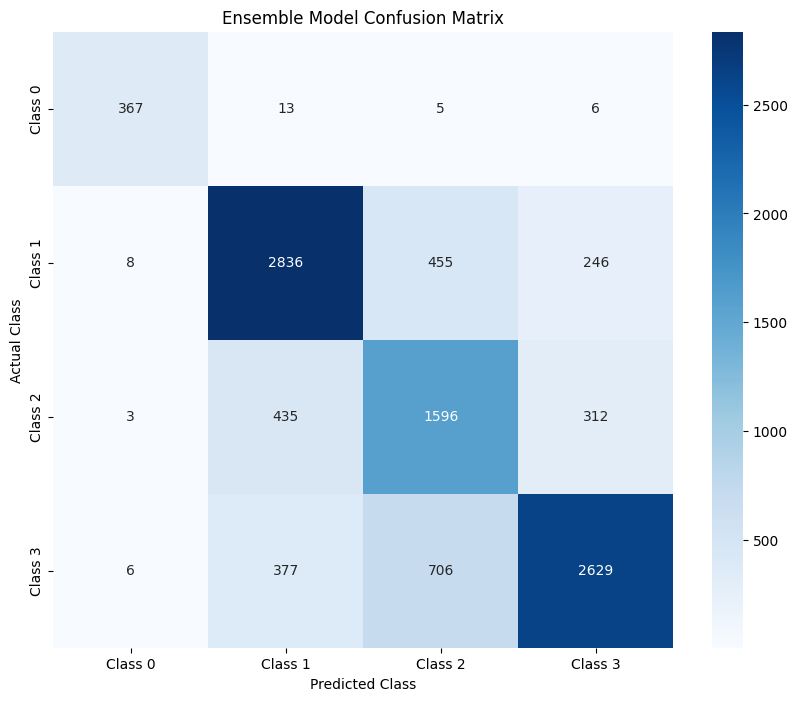

In [12]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, accuracy_score
import lightgbm as lgb
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier

# 데이터 준비
X = advanced_features_df
y = valid_flow_data['duration_class']

# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print(f"\n📊 데이터 준비: 학습 {X_train.shape[0]:,}개 | 검증 {X_test.shape[0]:,}개 | 특징 {X_train.shape[1]:,}개")

# 클래스 가중치 계산
classes = np.unique(y_train)
weights = compute_class_weight('balanced', classes=classes, y=y_train)
class_weights_dict = {int(cls): weight for cls, weight in zip(classes, weights)}
print("📌 클래스 가중치:", class_weights_dict)
# =======================================================
# 🧪 4단계: 개별 모델 학습
# =======================================================
print("\n" + "="*80)
print("🧪 4단계: 개별 모델 학습")
print("="*80)

# 1. XGBoost 모델 학습
print("🔥 훈련 시작: XGBoost...")
start_time = time.time()
xgb_model = xgb.XGBClassifier(
    n_estimators=400,
    max_depth=10,
    learning_rate=0.03,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    scale_pos_weight=None,  # sample_weight 사용 시 None으로 설정
    tree_method='hist',
    n_jobs=-1
)
# XGBoost는 sample_weight 인자를 fit 메서드에서 지원
xgb_model.fit(X_train, y_train, sample_weight=y_train.map(class_weights_dict))
print(f"✅ XGBoost 훈련 완료! (소요 시간: {time.time() - start_time:.2f}초)")


# 2. RandomForest 모델 학습
print("\n🌳 훈련 시작: RandomForest...")
start_time = time.time()
rf_model = RandomForestClassifier(
    n_estimators=300,
    max_depth=20,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    class_weight=class_weights_dict,
    n_jobs=-1
)
rf_model.fit(X_train, y_train)
print(f"✅ RandomForest 훈련 완료! (소요 시간: {time.time() - start_time:.2f}초)")


# 3. ExtraTrees 모델 학습
print("\n🌲 훈련 시작: ExtraTrees...")
start_time = time.time()
et_model = ExtraTreesClassifier(
    n_estimators=200,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=2,
    random_state=42,
    class_weight=class_weights_dict,
    n_jobs=-1
)
et_model.fit(X_train, y_train)
print(f"✅ ExtraTrees 훈련 완료! (소요 시간: {time.time() - start_time:.2f}초)")


# =======================================================
# 🤝 5단계: 앙상블 (소프트 보팅)
# =======================================================
print("\n" + "="*80)
print("🤝 5단계: 소프트 보팅(Soft Voting) 앙상블")
print("="*80)
print("🗳️ 각 모델의 예측 확률을 계산하여 평균을 냅니다... (가중치 1:1:1)")

# 각 모델로부터 테스트 데이터에 대한 클래스별 예측 확률을 얻음
xgb_probs = xgb_model.predict_proba(X_test)
rf_probs = rf_model.predict_proba(X_test)
et_probs = et_model.predict_proba(X_test)

# 세 모델의 예측 확률을 1:1:1 가중치로 평균
ensembled_probs = (xgb_probs + rf_probs + et_probs) / 3.0

# 가장 높은 평균 확률을 가진 클래스를 최종 예측값으로 선택
ensemble_pred = np.argmax(ensembled_probs, axis=1)

print("✅ 앙상블 예측 완료!")


# =======================================================
# 🏆 6단계: 최종 성능 평가
# =======================================================
print("\n" + "="*80)
print("🏆 6단계: 최종 성능 평가 (앙상블 모델)")
print("="*80)

# 정확도 출력
accuracy = accuracy_score(y_test, ensemble_pred)
print(f"===== 📊 소프트 보팅 앙상블 성능 =====")
print(f"정확도: {accuracy:.4f}\n")

# Classification Report 출력
print(classification_report(y_test, ensemble_pred, target_names=[f"Class {c}" for c in classes]))

# Confusion Matrix 시각화
cm = confusion_matrix(y_test, ensemble_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=[f"Class {c}" for c in classes], 
            yticklabels=[f"Class {c}" for c in classes])
plt.title('Ensemble Model Confusion Matrix')
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')
plt.show()


In [13]:
import joblib

# 앙상블 모델 저장 (개별 모델 파일도 필요하면 따로 저장 가능)
joblib.dump({
    'xgb_model': xgb_model,
    'rf_model': rf_model,
    'et_model': et_model,
}, 'model/ensemble_dur_0809.pkl')

print("✅ 앙상블 및 개별 모델들이 'model/ensemble_dur_0809.pkl' 에 저장되었습니다.")

✅ 앙상블 및 개별 모델들이 'model/ensemble_dur_0809.pkl' 에 저장되었습니다.


| 모델               | 정확도 (Accuracy) | Macro F1-score | Class 0 F1 | Class 1 F1 | Class 2 F1 | Class 3 F1 |
| ---------------- | -------------- | -------------- | ---------- | ---------- | ---------- | ---------- |
| **앙상블**          | 0.7428         | 0.78           | 0.95       | 0.79       | 0.62       | 0.76       |
| **XGBoost**      | 0.7418         | 0.7795         | 0.9493     | 0.7830     | 0.6259     | 0.7599     |
| **LightGBM**     | 0.7370         | 0.7733         | 0.9362     | 0.7817     | 0.6187     | 0.7566     |
| **RandomForest** | 0.7338         | 0.7747         | 0.9532     | 0.7812     | 0.6097     | 0.7547     |
| **CatBoost**     | 0.7225         | 0.7521         | 0.8878     | 0.7635     | 0.6085     | 0.7486     |
| **ExtraTrees**   | 0.7317         | 0.7545         | 0.8703     | 0.7711     | 0.6205     | 0.7560     |


In [14]:
# ======================================================================
# 🚀 "Volume" 과제 최종 평가 파이프라인 (가변 패킷 처리 명시)
# ======================================================================
print("✅ 라이브러리 로딩 시작...")
import joblib
import pandas as pd
import numpy as np
import time
import os
import warnings

# 모델 및 평가 관련 라이브러리
import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from sklearn.utils.class_weight import compute_class_weight

# 시각화 라이브러리
import seaborn as sns
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')
print("✅ 라이브러리 로딩 완료!")


# =======================================================
# 🧹 1단계: 정제된 데이터 로딩
# =======================================================
print("\n" + "="*80)
print("🧹 1단계: 정제된 데이터 로딩")
print("="*80)
print("📂 이전 단계에서 생성한 '정제된' 데이터 파일을 불러옵니다...")
try:
    flow_data = joblib.load("task2_data/train_flow_data_cleaned.pkl")
    all_packets = joblib.load("task2_data/train_packet_data_cleaned.pkl")
    print(f"✅ 정제된 Flow 데이터 ({len(flow_data):,}개) 로딩 완료")
    print(f"✅ 정제된 Packet 데이터 ({len(all_packets):,}개) 로딩 완료")
except FileNotFoundError:
    print("❌ 정제된 파일을 찾을 수 없습니다!")
    print("   먼저 이전 파이프라인의 '데이터 정제' 부분을 실행하여 _cleaned.pkl 파일을 생성해주세요.")
    # exit() # 실제 실행 시에는 주석 해제


# =======================================================
# 🎯 2단계: 대표 샘플 생성 (층화 추출)
# =======================================================
print("\n" + "="*80)
print("🎯 2단계: 대표 샘플 생성 (층화 추출)")
print("="*80)
target_total_samples = 50000  
print(f"🎯 목표 총 샘플 수: {target_total_samples:,}개")
stratify_key = flow_data['volume_class'].astype(str)
stratified_sampler = StratifiedShuffleSplit(n_splits=1, train_size=target_total_samples, random_state=42)
indices = np.arange(len(flow_data))
sampled_indices, _ = next(stratified_sampler.split(indices, stratify_key))
print(f"✅ 샘플링 완료! 총 {len(sampled_indices):,}개 대표 샘플 인덱스 확보.")


# =======================================================
# 🔧 3단계: 특징 추출 함수 정의 (가변 처리 로직 강조)
# =======================================================
print("\n" + "="*80)
print("🔧 3단계: 특징 추출 함수 정의 (가변 처리 로직 강조)")
print("="*80)

def extract_features_for_n_packets(packets, n):
    """
    주어진 'n'을 최대치로 하여, 실제 사용 가능한 패킷만으로 특징을 추출합니다.
    """
    num_packets_available = len(packets)
    if num_packets_available == 0: return {}

    # ✨✨✨ 사용자 요청 핵심 로직 ✨✨✨
    # 사용할 패킷 수는 최대 n개와 실제 패킷 수 중 '더 작은 값'으로 결정됩니다.
    # 즉, 패킷이 1개만 있으면 1개만 사용하고, 2개 있으면 2개만 사용합니다.
    n_to_use = min(n, num_packets_available)
    packets = packets.iloc[:n_to_use]
    
    features = {}
    # (이하 특징 추출 로직은 이전과 동일)
    for col in ['ip_len', 'ip_hdr_len', 'tcp_len', 'tcp_hdr_len']:
        if col in packets.columns:
            values = packets[col].values
            features[f'{col}_mean_{n}'] = np.mean(values)
            features[f'{col}_std_{n}'] = np.std(values) if len(values) > 1 else 0
            features[f'{col}_sum_{n}'] = np.sum(values)
    if 'packet_capture_time' in packets.columns and len(packets) > 1:
        try:
            times = pd.to_datetime(packets['packet_capture_time'])
            time_diffs = np.diff(times).astype('timedelta64[us]').astype(float)
            if len(time_diffs) > 0:
                features[f'inter_time_mean_{n}'] = np.mean(time_diffs)
                features[f'inter_time_std_{n}'] = np.std(time_diffs) if len(time_diffs) > 1 else 0
        except Exception: pass
    if 'tcp_window_size' in packets.columns:
        features[f'initial_tcp_win_size'] = packets['tcp_window_size'].iloc[0]
        features[f'mean_tcp_win_size_{n}'] = packets['tcp_window_size'].mean()
    flag_cols = ['tcp_flags_ack', 'tcp_flags_push', 'tcp_flags_reset', 'tcp_flags_syn', 'tcp_flags_fin']
    for flag in flag_cols:
        if flag in packets.columns:
            features[f'{flag}_count_{n}'] = packets[flag].sum()
    for col in ['ip_tos', 'ip_ttl']:
        if col in packets.columns:
            values = packets[col].values
            features[f'{col}_mean_{n}'] = np.mean(values)
            features[f'first_{col}'] = values[0]
    if 'ip_len' in packets.columns and 'tcp_len' in packets.columns:
        total_ip_len = packets['ip_len'].sum()
        total_tcp_len = packets['tcp_len'].sum()
        features[f'payload_ratio_{n}'] = total_tcp_len / total_ip_len if total_ip_len > 0 else 0
    return features
print("✅ 특징 추출 함수 준비 완료! (가변 패킷 처리 로직 포함)")


# =======================================================
# 🔬 4단계: 최종 데이터 준비
# =======================================================
print("\n" + "="*80)
print("🔬 4단계: 최종 데이터 준비 (최대 N=3)")
print("="*80)

N_MAX = 3 # 이제 이 변수는 '최대' 패킷 수를 의미합니다.
print(f"🚀 최대 N={N_MAX} 값을 기준으로 특징 추출 중...")
start_time = time.time()
features_list = []
successful_indices = []

for i in range(len(sampled_indices)):
    original_idx = sampled_indices[i]
    try:
        packet_df = all_packets[original_idx]
        if isinstance(packet_df, pd.DataFrame) and not packet_df.empty:
            # 함수 내부에서 실제 패킷 수를 감지하여 처리하므로, N_MAX만 넘겨주면 됩니다.
            features = extract_features_for_n_packets(packet_df, n=N_MAX)
            if features:
                features_list.append(features)
                successful_indices.append(i)
    except Exception: continue

X = pd.DataFrame(features_list).fillna(0)
y = flow_data.iloc[sampled_indices].reset_index(drop=True).loc[successful_indices, 'volume_class']
print(f"✅ 특징 추출 완료! (소요 시간: {time.time() - start_time:.2f}초, 최종 샘플 수: {len(X):,}개)")

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print(f"📊 데이터 분할 완료: 학습 {len(X_train):,}개 | 검증 {len(X_test):,}개")

print("\n⏳ 클래스 가중치를 계산합니다...")
volume_classes = np.unique(y_train)
volume_weights_array = compute_class_weight(class_weight='balanced', classes=volume_classes, y=y_train)
volume_class_weights_dict = {int(cls): weight for cls, weight in zip(volume_classes, volume_weights_array)}
sample_weights = np.array([volume_class_weights_dict[i] for i in y_train])
print(f"✅ 계산된 가중치(dict): {volume_class_weights_dict}")


✅ 라이브러리 로딩 시작...
✅ 라이브러리 로딩 완료!

🧹 1단계: 정제된 데이터 로딩
📂 이전 단계에서 생성한 '정제된' 데이터 파일을 불러옵니다...
✅ 정제된 Flow 데이터 (381,559개) 로딩 완료
✅ 정제된 Packet 데이터 (381,559개) 로딩 완료

🎯 2단계: 대표 샘플 생성 (층화 추출)
🎯 목표 총 샘플 수: 50,000개
✅ 샘플링 완료! 총 50,000개 대표 샘플 인덱스 확보.

🔧 3단계: 특징 추출 함수 정의 (가변 처리 로직 강조)
✅ 특징 추출 함수 준비 완료! (가변 패킷 처리 로직 포함)

🔬 4단계: 최종 데이터 준비 (최대 N=3)
🚀 최대 N=3 값을 기준으로 특징 추출 중...
✅ 특징 추출 완료! (소요 시간: 72.94초, 최종 샘플 수: 50,000개)
📊 데이터 분할 완료: 학습 40,000개 | 검증 10,000개

⏳ 클래스 가중치를 계산합니다...
✅ 계산된 가중치(dict): {0: np.float64(0.7290755322251385), 1: np.float64(1.031140441328109), 2: np.float64(0.7028394714647175), 3: np.float64(4.2408821034775235)}



🧪 5단계: 개별 모델 정의 및 학습
사용될 하이퍼파라미터:
  - RandomForest: {'n_estimators': 855, 'max_depth': 22}
  - LightGBM: {'n_estimators': 843, 'learning_rate': 0.1477594092687316}
  - CatBoost: {'iterations': 839, 'learning_rate': 0.1762109604779554, 'depth': 10}

🌳 훈련 시작: RandomForest...
✅ RandomForest 훈련 완료! (소요 시간: 6.09초)

💡 훈련 시작: LightGBM...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006969 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3806
[LightGBM] [Info] Number of data points in the train set: 40000, number of used features: 24
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
✅ LightGBM 훈련 완료! (소요 시간: 6.25초)

🐾 훈련 시작: CatBoost...
✅ CatBoost 훈련 완료! (소요 시간: 69.86초)

🤝 6단계: 소프트 보팅(Soft Voting) 앙상블
🗳️ 각 모델의 예측 확률을 계산하여 평균을 냅니다... (가중치 1:1

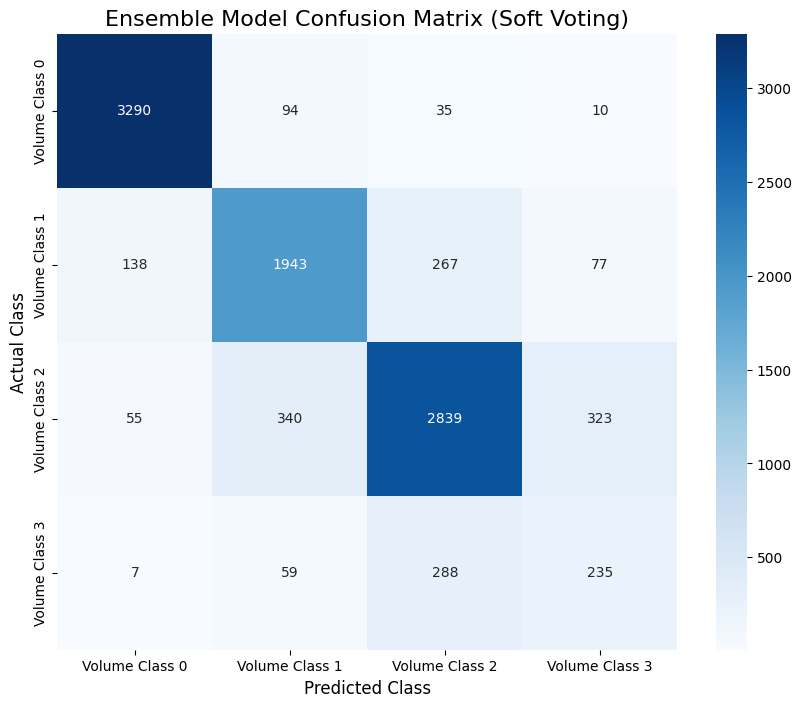

In [15]:
# =======================================================
# 🧪 5단계: 개별 모델 정의 및 학습
# =======================================================
print("\n" + "="*80)
print("🧪 5단계: 개별 모델 정의 및 학습")
print("="*80)

# 하이퍼파라미터 정의
params = {
    'RandomForest': {'n_estimators': 855, 'max_depth': 22},
    'LightGBM': {'n_estimators': 843, 'learning_rate': 0.1477594092687316},
    'CatBoost': {'iterations': 839, 'learning_rate': 0.1762109604779554, 'depth': 10}
}
print("사용될 하이퍼파라미터:")
for model_name, p in params.items():
    print(f"  - {model_name}: {p}")

# 1. RandomForest 모델 학습
print("\n🌳 훈련 시작: RandomForest...")
start_time = time.time()
rf_params = params['RandomForest']
rf_model = RandomForestClassifier(
    n_estimators=rf_params['n_estimators'],
    max_depth=rf_params['max_depth'],
    random_state=42,
    class_weight=volume_class_weights_dict,  # 클래스 가중치 적용
    n_jobs=-1
)
rf_model.fit(X_train, y_train)
print(f"✅ RandomForest 훈련 완료! (소요 시간: {time.time() - start_time:.2f}초)")

# 2. LightGBM 모델 학습
print("\n💡 훈련 시작: LightGBM...")
start_time = time.time()
lgbm_params = params['LightGBM']
lgbm_model = lgb.LGBMClassifier(
    n_estimators=lgbm_params['n_estimators'],
    learning_rate=lgbm_params['learning_rate'],
    random_state=42,
    class_weight=volume_class_weights_dict,  # 클래스 가중치 적용
    n_jobs=-1
)
lgbm_model.fit(X_train, y_train)
print(f"✅ LightGBM 훈련 완료! (소요 시간: {time.time() - start_time:.2f}초)")

# 3. CatBoost 모델 학습
print("\n🐾 훈련 시작: CatBoost...")
start_time = time.time()
cat_params = params['CatBoost']
cat_model = CatBoostClassifier(
    iterations=cat_params['iterations'],
    learning_rate=cat_params['learning_rate'],
    depth=cat_params['depth'],
    random_state=42,
    class_weights=volume_class_weights_dict,  # 클래스 가중치 적용
    verbose=0,  # 학습 로그 숨기기
    thread_count=-1
)
cat_model.fit(X_train, y_train)
print(f"✅ CatBoost 훈련 완료! (소요 시간: {time.time() - start_time:.2f}초)")


# =======================================================
# 🤝 6단계: 앙상블 (소프트 보팅)
# =======================================================
print("\n" + "="*80)
print("🤝 6단계: 소프트 보팅(Soft Voting) 앙상블")
print("="*80)
print("🗳️ 각 모델의 예측 확률을 계산하여 평균을 냅니다... (가중치 1:1:1)")

# 각 모델로부터 테스트 데이터에 대한 클래스별 예측 확률을 얻음
rf_probs = rf_model.predict_proba(X_test)
lgbm_probs = lgbm_model.predict_proba(X_test)
cat_probs = cat_model.predict_proba(X_test)

# 세 모델의 예측 확률을 1:1:1 가중치로 평균
# (가중치가 모두 같으므로 단순히 더해서 3으로 나눔)
ensembled_probs = (rf_probs + lgbm_probs + cat_probs) / 3.0

# 가장 높은 평균 확률을 가진 클래스를 최종 예측값으로 선택
ensemble_pred = np.argmax(ensembled_probs, axis=1)

print("✅ 앙상블 예측 완료!")


# =======================================================
# 🏆 7단계: 최종 성능 평가
# =======================================================
print("\n" + "="*80)
print("🏆 7단계: 최종 성능 평가 (앙상블 모델)")
print("="*80)

# 정확도 및 F1 Score 출력
accuracy = accuracy_score(y_test, ensemble_pred)
f1 = f1_score(y_test, ensemble_pred, average='weighted') # 가중 평균 F1-Score

print(f"===== 📊 소프트 보팅 앙상블 성능 =====")
print(f"정확도: {accuracy:.4f}")
print(f"Weighted F1-Score: {f1:.4f}\n")

# Classification Report 출력 (클래스별 상세 지표)
target_names = [f"Volume Class {c}" for c in volume_classes]
print(classification_report(y_test, ensemble_pred, target_names=target_names))

# Confusion Matrix 시각화
cm = confusion_matrix(y_test, ensemble_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=target_names, 
            yticklabels=target_names)
plt.title('Ensemble Model Confusion Matrix (Soft Voting)', fontsize=16)
plt.ylabel('Actual Class', fontsize=12)
plt.xlabel('Predicted Class', fontsize=12)
plt.show()


In [16]:
import joblib

models_dict = {
    'RandomForest': rf_model,
    'LightGBM': lgbm_model,
    'CatBoost': cat_model
}

joblib.dump(models_dict, 'model/ensemble_volume_0809.pkl')
print("✅ 모델 딕셔너리로 저장 완료: model/ensemble_volume_0809.pkl")


✅ 모델 딕셔너리로 저장 완료: model/ensemble_volume_0809.pkl


| 모델명                   | 정확도 (Accuracy) | Weighted F1-Score | Class 0 F1 | Class 1 F1 | Class 2 F1 | Class 3 F1 |
| --------------------- | -------------- | ----------------- | ---------- | ---------- | ---------- | ---------- |
| **앙상블 (Soft Voting)** | 0.8307         | 0.8315            | 0.95       | 0.80       | 0.81       | 0.38       |
| RandomForest          | 0.8348         | 0.8315            | 0.95       | 0.80       | 0.82       | 0.35       |
| ExtraTrees            | 0.8250         | 0.8200            | 0.95       | 0.78       | 0.81       | 0.36       |
| LightGBM              | 0.8218         | 0.8200            | 0.95       | 0.79       | 0.80       | 0.38       |
| XGBoost               | 0.8200         | 0.8200            | 0.95       | 0.78       | 0.80       | 0.36       |
| CatBoost              | 0.8107         | 0.8100            | 0.95       | 0.79       | 0.78       | 0.37       |
